# IDEA
-----------

We have seen that the data in outdated and mislabeled. Fitting a model to mislabeled and outdated data would not be appropriate to compare the model performance to human level. Here we employ a Bootstrapping mechanism to correct mislabels.

* We manually collect different variety of land and house images (1000 each) and make sure that the labels for collected images are consistent with the images.
* We start the regular bootstrap process.
    * We fit a model with these 2000 images and save the checkpoints to the disk.
    * We test the model on our large test corpus.
    * We place a rule based filtering criteria, such as, 
        * Find all misclassified images where the model prediction is 100% for 2 or more checkpoints 
        * Flag if the parcel was cropped based on bounding box.
        * And few other varying criteria.
        This is preferable because, let say that 2 checkpoints predicted an images with 100% house and we were able to flag it at a cropped region. Given the fact that 95% of images that were cropped based on building polygon were images of house. We can with a very good certainity say that the images is actually a house and was mislabeled as land.
    * Items that made it thought the filtering process are relabeled and the images are placed into the new labeled directories.
* Iterate: over and over

In [1]:
from __future__ import division, print_function, absolute_import
import logging
import time
import tensorflow as tf
import os
tf.logging.set_verbosity(tf.logging.ERROR)
import numpy as np
from config import pathDict
from conv_net.train import Train
from conv_net.test import Test
from data_transformation.data_prep import get_intersecting_images_pin, DumpBatches
from plot import Plot
import pandas as pd
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")


which_net = 'resnet'
batch_prepare = True
train = True
test = True

INPUT the RUN NAME: Options : ("A new run name" or "Any Previous Run Name"
 WHICH_RUN = new_test
INPUT: Image-type OPTIONS: (assessor, assessor_code, aerial, overlayed, aerial_cropped, streetside and ensemble 
 IMAGE_TYPE = aerial_cropped


In [2]:
# from clean_directories import clean
# clean(dict(overlayed='summary,batch'),which_vendor='google', which_model='resnet')

## RESTART WITH NEW_TEST: PREPARE/DUMP BATCHES:

In [2]:
start_time = time.time()

max_batches = None

if batch_prepare:
    start_time = time.time()
    
    cmn_land_pins, cmn_house_pins = get_intersecting_images_pin(is_assessor=False, is_aerial=False,
                                                                is_streetside=False, is_overlayed=False,
                                                                is_aerial_cropped=True, equal_proportion=True)
    print(len(cmn_land_pins), len(cmn_house_pins))
    
    tr_batch_size = 128
    ts_batch_size = (len(cmn_land_pins) + len(cmn_house_pins)) // 10
    cv_batch_size = (len(cmn_land_pins) + len(cmn_house_pins)) // 10
    
    params = dict(
            image_type='aerial_cropped',
            img_in_shape=[400, 400, 3],
            img_out_shape=[224, 224, 3],
            img_resize_shape=[128, 128, 3],
            img_crop_shape=[128, 128, 3],
            tr_batch_size = tr_batch_size,
            cv_batch_size = cv_batch_size,
            ts_batch_size = ts_batch_size,
            enable_rotation=True,
            shuffle_seed=881,
            get_stats=True,
            max_batches=max_batches)
    
    obj_cb = DumpBatches(params)
    obj_cb.dumpStratifiedBatches_balanced_class(cmn_land_pins, cmn_house_pins, is_cvalid_test=False)

print ('--------------- %s seconds ------------------'%(time.time() - start_time))


1263 1263
2526 2526 2526 2526 2526=== 18
--------------- 31.27702045440674 seconds ------------------


# TRAIN MODEL
------------

# VARIATION 2: Dropouts after every layer: Learning is pretty slow but improves gradually.
-----------------------

In [5]:
max_batches = 17
start_time = time.time()
if train:
    tr_obj = Train(dict(pprocessor_inp_img_shape=[224,224,3],
                        pprocessor_inp_crop_shape=[],
                        model_inp_img_shape=[224,224,3],
                        use_checkpoint=True,
                        save_checkpoint=True,
                        write_tensorboard_summary=False
                        ),
              device_type='gpu',
              which_net='resnet')
    (tr_loss_arr, tr_acc_arr, tr_precision_arr, tr_recall_arr, 
     cv_loss_arr, cv_acc_arr, cv_precision_arr, cv_recall_arr,
     l_rate_arr)  = tr_obj.run(num_epochs=30, num_batches=max_batches, cv_num_batches=1, get_stats_at=10)# + 1)
    
print('----------%s seconds------------'%(str(time.time() - start_time)))

Dumping/Retreiving Checkpoints to/from %s C:\Users\newline\Documents\ImageClassification\data\checkpoints\new_test\aerial_cropped\resnet
Learning Rate: Initial:  0.0005
Checkpoint latest at:  C:\Users\newline\Documents\ImageClassification\data\checkpoints\new_test\aerial_cropped\resnet\resnet_epoch_0_batch_9
----------745.1838419437408 seconds------------


Mean Values: train_loss = 1.22114, train_acc = 0.865592, train_precision = 0.881910196176, train_recall = 0.857682291667, cv_loss = 1.14752001365, cv_acc = 0.859459463755, cv_precision = 0.857232431013, cv_recall = 0.874474474474


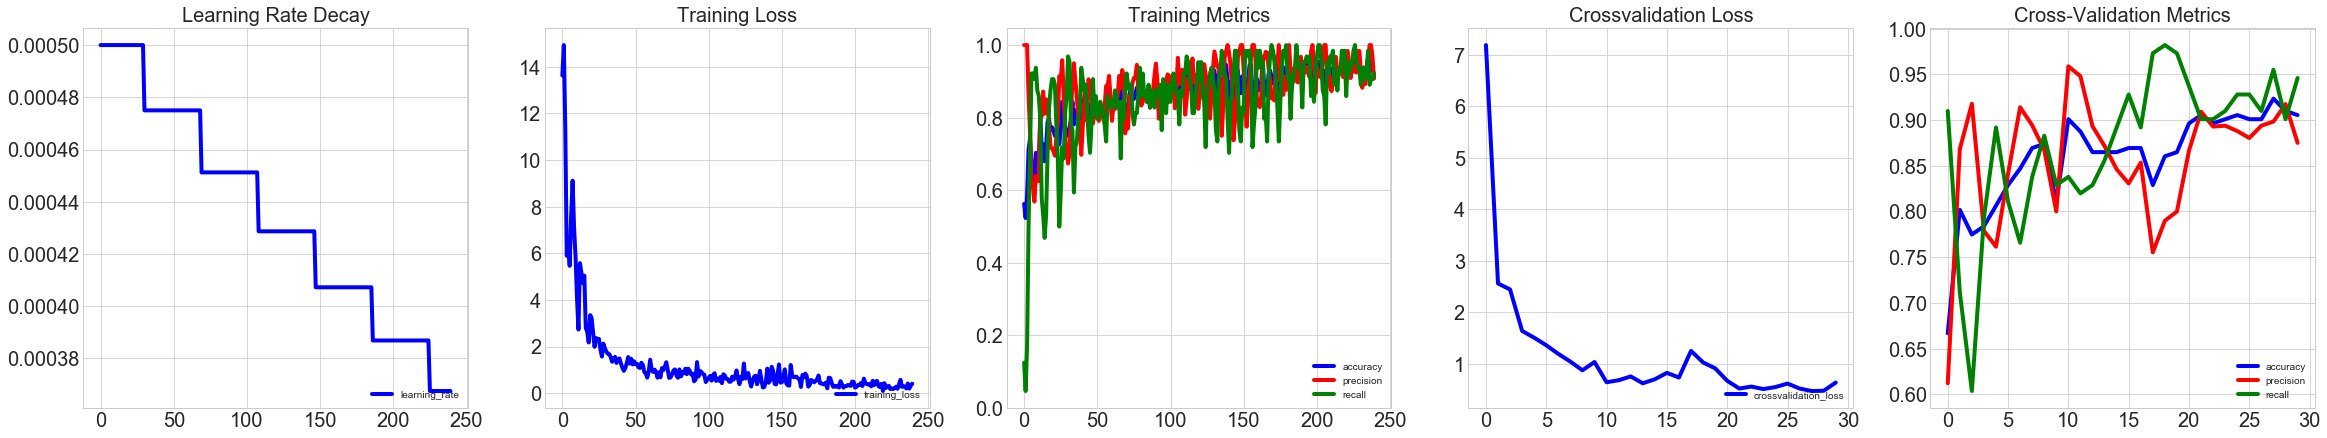

In [6]:
print ('Mean Values: train_loss = %s, train_acc = %s, train_precision = %s, train_recall = %s, cv_loss = %s, cv_acc = %s, cv_precision = %s, cv_recall = %s'%(
    np.mean(tr_loss_arr), np.mean(tr_acc_arr), np.mean(tr_precision_arr), np.mean(tr_recall_arr), np.mean(cv_loss_arr), np.mean(cv_acc_arr), np.mean(cv_precision_arr), np.mean(cv_recall_arr)))
oj = Plot(rows=1, columns=5, fig_size=(40,7))

l_rate_df = pd.DataFrame(l_rate_arr, columns=['learning_rate'])
oj.vizualize(data=l_rate_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Learning Rate Decay'})

tr_loss_df = pd.DataFrame(tr_loss_arr, columns=['training_loss'])
oj.vizualize(data=tr_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Training Loss'})
tr_data = pd.DataFrame(np.column_stack((tr_acc_arr, tr_precision_arr, tr_recall_arr)), columns=['accuracy', 'precision', 'recall'])
oj.vizualize(data=tr_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Training Metrics'})

cv_loss_df = pd.DataFrame(cv_loss_arr, columns=['crossvalidation_loss'])
oj.vizualize(data=cv_loss_df, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Crossvalidation Loss'})
cv_data = pd.DataFrame(np.column_stack((cv_acc_arr, cv_precision_arr, cv_recall_arr)), columns=['accuracy', 'precision', 'recall'])
oj.vizualize(data=cv_data, colX=None, colY=None, label_col=None, viz_type='line', params={'title':'Cross-Validation Metrics'})

In [8]:
which_data = 'cvalid'
tsoj = Test(params=dict(pprocessor_inp_img_shape=[224,224,3],
                        pprocessor_inp_crop_shape=[],
                        model_inp_img_shape=[224, 224, 3]),
                    device_type = 'gpu',
                    which_net='resnet')
fnl_tst_metric_stack = tsoj.run(use_checkpoint_for_run='new_test',
                                use_checkpoint_for_imageType='aerial_cropped',
                                optional_batch_name=which_data,
                                which_checkpoint='all',
                                which_data=which_data,
                                dump_stats=True)

Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\new_test\aerial_cropped, batch_names: ['cvalid']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\new_test\aerial_cropped, batch_names: ['cvalid']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\new_test\aerial_cropped, batch_names: ['cvalid']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\new_test\aerial_cropped, batch_names: ['cvalid']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data\new_test\aerial_cropped, batch_names: ['cvalid']
Test Graphs: RESNET
Learning Rate: Initial:  0.0005
Batch path C:\Users\newline\Documents\ImageClassification\data\batch_data

In [9]:
prediction_outcomes_path = os.path.join(pathDict['statistics_path'], 'prediction_stats', 'cvalid_pred_outcomes.csv')
prediction_metrics_path = os.path.join(pathDict['statistics_path'], 'prediction_stats', 'cvalid_pred_metrics.csv')
prediction_outcomes = pd.read_csv(prediction_outcomes_path)
prediction_metrics = pd.read_csv(prediction_metrics_path)
prediction_metrics

,checkpoint,dataset_type,test_loss,test_acc,test_precsion,test_recall
0,epoch_0_batch_9,cvalid,13.468,0.626,1.000,0.252
1,epoch_25_batch_17,cvalid,0.800,0.914,0.890,0.946
2,epoch_26_batch_17,cvalid,0.642,0.919,0.919,0.919
3,epoch_27_batch_17,cvalid,0.676,0.914,0.904,0.928
4,epoch_28_batch_17,cvalid,0.760,0.905,0.902,0.910
5,epoch_29_batch_17,cvalid,0.590,0.923,0.892,0.964
